In [2]:
from xii import *   
import numpy as np
import imp as imp
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

from fenics import *
import sympy as sym
import matplotlib.pyplot as plt
import gfem as solvers

from gfem import refine_mesh

Missing HsMG for fract norm computing


## Generalized Finite Element Methods

### Model problem

Let $\Omega=(0,1)$. As our model problem we take the Poisson equation
\begin{align*}
-u''(x) &= f(x) \in {\Omega} \\
& + \text{bcs},
\end{align*}
with $f \in L^2(\Omega)$.


Let $B(u,v)=(u',v')$ and $F(v)=(f,v)$. The weak formulation of this problem then reads:

Find $u \in H^1(\Omega)$ such that 
\begin{align*}
B(u,v) = F(v) \quad \forall v \in H^1(\Omega).
\end{align*}

We solve this problem using standard FEM, GFEM and Stable GFEM.

### Test problems

We consider two test problems: A bump function
\begin{align*}
 u_a(x) &=
  \begin{cases}
   -\exp \left( -\frac{1}{1-\beta^2 (x-0.5)^2}  \right)   & \text{if } \vert x - 0.5\vert < 1/\beta \\
   0        & \text{otherwise}
  \end{cases}
\end{align*}
for different values of $\beta$, and 
\begin{align*}
u_a(x) = x^\alpha.
\end{align*}

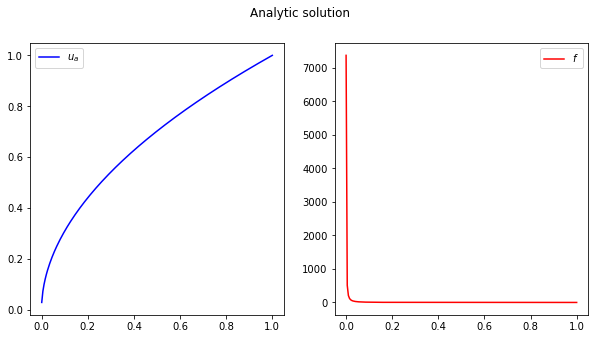

In [3]:
## Set up test problem

test = 'Bump'
test = 'Babushka'

sym.printing.ccode

x = sym.symbols('x[0]')

if test=='Babushka':
    ## Babushka example, u=x^alpha with 0.5 < alpha < 1.5
    alpha=0.51
    
    eps  = 1.0e-3 # we add in an epsilon to avoid dividing by 0 in f
    
    u_a = (x+eps)**alpha
    f = -alpha*(alpha-1.0)*(x+eps)**(alpha-2.0) # corresponding rhs
    
    Ie = 1.0 # no cut-off
    
    # Enrichment function
    phi = u_a #
    
if test=='Bump' :
    ## Mollifier function with steep gradients
    
    beta=2.5
    u_a = -sym.exp(-1.0/(1.0-beta**2.0*(x-0.5)**2.0))
    u_a *= 1.0/sym.exp(-1.0) #normalize to 1
    
    f = -sym.diff(sym.diff(u_a,x),x) # corresponding rhs
    
    # Enrichment function
    phi = u_a

    # Cut-off function
    Ie = sym.LessThan(sym.Abs(x-0.5), 1.0/beta - 0.01)

# Convert from sympy to fenics expressions
u_a, phi, f, Ie = [sym.printing.ccode(expr) for expr in [u_a, phi, f, Ie]]

u_a = '(' + u_a + ')*' + '(' + Ie + ')' # sympy cannot convert expressions 
phi = '(' + phi + ')*' + '(' + Ie + ')' # involving "less than" to ccode
f = '(' + f + ')*' + '(' + Ie + ')'     # so we add the cut-off function ourselves

u_a = Expression(u_a, degree=2)
phi = Expression(phi, degree=2)
f = Expression(f, degree=2)

## Plot solution
Vfine = FunctionSpace(UnitIntervalMesh(200), 'CG', 1)
uai = interpolate(u_a, Vfine)
fi = interpolate(f, Vfine)


fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Analytic solution')
axs[0].plot(Vfine.tabulate_dof_coordinates(), uai.vector().get_local(), 'b', label='$u_a$')
axs[1].plot(Vfine.tabulate_dof_coordinates(), fi.vector().get_local(), 'r', label='$f$')
axs[0].legend(); axs[1].legend();

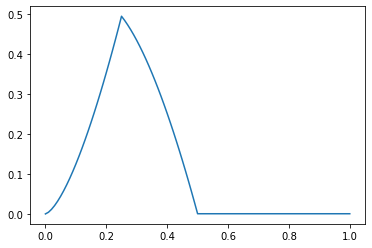

In [12]:
meshc = UnitIntervalMesh(4)
meshf = UnitIntervalMesh(100)
Vc = FunctionSpace(meshc, 'CG', 1)
Vf = FunctionSpace(meshf, 'CG', 1)
f = Function(Vc)
f.vector()[3] = 1
fenr = project(f*phi, Vf)


plot(fenr)

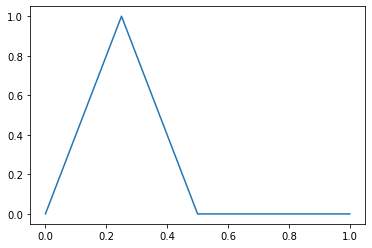

In [13]:
plot(f)

In [4]:
# The GFEM method will enrich using phi

# The stabilized GFEM will enrich using \bar{phi}=\phi - I(\phi)
# where I(\phi) is the interpolation of phi on the space of linear

class Phi_Bar(UserExpression):
    def __init__(self, degree, phi, phi1, **kwargs):
        self.degree=degree
        self.phi1=phi1
        self.phi=phi
        super().__init__(**kwargs)
    
    def eval(self, value, x):
        value[0] = (self.phi(x) -  self.phi1(x))
    
    def value_shape(self):
        return ()

In [6]:
# Solve using standard FEM, GFEM and Stable GFEM
# recording and printing errors as we go


form_str = '%1.3f (%1.1f)  %1.3f(%1.1f)  %1.1e   '
form_str = '%1.3f  '+form_str+form_str+form_str

print('       Standard FEM                       Stable GFEM                        Enr. FEM ')
print('h      |u_e|_L2     |u_e|_H1    k         |u_e|_L2     |u_e|_H1    k         |u_e|_L2    |u_e|_H1   k ')

imp.reload(solvers)

uhs, uh_enrs, uh_sgfems, error, error_enr, error_st_enr, hs = [],[],[],[],[],[],[]

Ns = [2, 4, 8, 16]

for ix_N, N in enumerate(Ns):
    
    # Set up mesh and function spaces
    mesh = UnitIntervalMesh(N)
    mesh_f = refine_mesh(mesh, 4, [0.2, 0.8]) # refined mesh for quadrature rule

    V, V2, V3 = [FunctionSpace(mesh, 'CG', i) for i in [1,2,3]]
    
    
    # Enrichment functions
    phi1 = interpolate(phi, FunctionSpace(mesh, 'CG', 1)) # I(phi) on linear space
    phi_bar = Phi_Bar(degree=3, phi=phi, phi1=phi1) # phi_bar = phi-I(phi), used for Stab GFEM
    phi_bari = interpolate(phi_bar, FunctionSpace(mesh_f, 'CG', 1))

    
    # Solve using different FE methods
    uh, k = solvers.StFEM(V, u_a, f)

    uh_enr, k_enr = solvers.GFEM(V, phi, mesh_f, u_a, f, custom_quad=True)
    
    uh_st_enr, k_st_enr = solvers.Stable_GFEM(V, phi_bar, mesh_f, u_a, f, custom_quad=True)
    
    uhs.append(uh); uh_enrs.append(uh_enr); uh_sgfems.append(uh_st_enr)
    
    
    # Interpolate analytic solution
    u_ai = interpolate(u_a, V3) 
    uf_ai = interpolate(u_a, FunctionSpace(mesh_f, 'CG', 3))
    
    
    # Calculate errors and convergence rates
    error.append([errornorm(uh, u_ai, norm) for norm in ['L2', 'H10']])
    error_enr.append([errornorm(uh_enr, uf_ai, norm) for norm in ['L2', 'H10']])
    error_st_enr.append([errornorm(uh_st_enr, uf_ai, norm) for norm in ['L2', 'H10']])
    hs.append(mesh.hmin())
    
    if ix_N==0: r, r_enr, r_st_enr, rk, rk_enr, rk_st_enr = [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]
    else:
        dh = np.log(hs[ix_N])-np.log(hs[ix_N-1])

        derror, derror_enr, derror_st_enr = [ [np.log(e_list[ix_N][n])-np.log(e_list[ix_N-1][n]) for n in [0,1]]
                                                            for e_list in [error, error_enr, error_st_enr] ]
        r, r_enr, r_st_enr = derror/dh, derror_enr/dh, derror_st_enr/dh
        
    # Make string showing the formatted errors
    print( form_str %(mesh.hmin(), error[-1][0], r[0], error[-1][1], r[1], k, 
                         error_st_enr[-1][0], r_st_enr[0], error_st_enr[-1][1], r_st_enr[1], k_st_enr,
                         error_enr[-1][0], r_enr[0], error_enr[-1][1], r_enr[1], k_enr) )

       Standard FEM                       Stable GFEM                        Enr. FEM 
h      |u_e|_L2     |u_e|_H1    k         |u_e|_L2     |u_e|_H1    k         |u_e|_L2    |u_e|_H1   k 
0.500  0.940 (0.0)  4.052(0.0)  6.1e+00   1.009 (0.0)  3.497(0.0)  5.1e+00   1.340 (0.0)  6.218(0.0)  1.1e+01   
0.250  0.283 (1.7)  2.072(1.0)  2.3e+01   0.229 (2.1)  1.146(1.6)  5.2e+01   0.239 (2.5)  1.135(2.5)  3.2e+02   
0.125  0.198 (0.5)  1.190(0.8)  6.9e+01   0.199 (0.2)  0.803(0.5)  1.4e+03   0.173 (0.5)  0.966(0.2)  9.5e+03   
0.062  0.027 (2.9)  0.660(0.9)  2.1e+02   nan (nan)  nan(nan)  2.4e+07   nan (nan)  nan(nan)  1.2e+09   


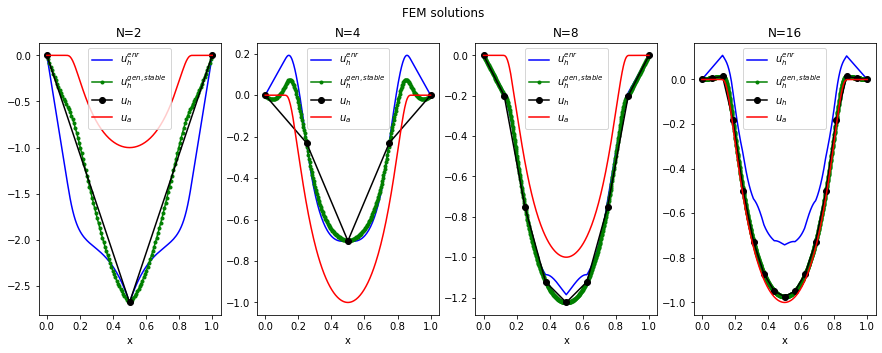

In [65]:
# Plot solution
fig, axs = plt.subplots(1,len(Ns),figsize=(15,5))
fig.suptitle('FEM solutions')


for i in range(len(axs)):
    axs[i].plot(uh_enrs[i].function_space().tabulate_dof_coordinates(), uh_enrs[i].vector().get_local(), 'b-', label='$u_h^{enr}$')
    
    axs[i].plot(uh_sgfems[i].function_space().tabulate_dof_coordinates(), uh_sgfems[i].vector().get_local(), 'g.-', label='$u_h^{gen, stable}$')

    axs[i].plot(uhs[i].function_space().tabulate_dof_coordinates(), uhs[i].vector().get_local(), 'ko-', label='$u_h$')
    
    uf_a1 = interpolate(u_a, uh_enrs[i].function_space())
    axs[i].plot(uf_a1.function_space().tabulate_dof_coordinates(), uf_a1.vector().get_local(), 'r', label='$u_a$')
    axs[i].legend()
    axs[i].set_xlabel('x')
    axs[i].set_title('N=%i'%Ns[i])
    
fig.savefig('alpha.png')